# **0. Library & Data Imports**

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from scipy.sparse import hstack, csr_matrix


In [5]:
df = pd.read_csv('data/data_bersih.csv')
df.head()

,sentimen,tweet,_exclaim,_question,_upper_rt,tweet_pp
0,negatif,Kata @prabowo Indonesia tidak dihargai bangsa ...,1,2,0.030769,prabowo indonesia tidak dihargai bangsa asing ...
1,netral,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib...",0,1,0.139785,batuan langka hadiah habib luthfi seharga mercy ?
2,netral,"Di era Jokowi, ekonomi Indonesia semakin baik....",0,0,0.103175,era indonesia baik indonesiamaju jokowilagi
3,positif,"Bagi Sumatera Selatan, Asian Games berdampak p...",1,0,0.054688,sumatera selatan asian games berdampak percaya...
4,negatif,Negara kita ngutang buat bngun infrastruktur y...,0,0,0.008197,negara ngutang bingung infrastruktur dipakai m...


In [6]:
X = df["tweet_pp"].astype(str)                       
le = LabelEncoder()
y = le.fit_transform(df["sentimen"].astype(str))

# 2) Split
X_text_train, X_text_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=16, stratify=y
)

# 3) TF-IDF 
vectorizer = TfidfVectorizer(max_features=800, min_df=3, ngram_range=(1, 3))
X_tfidf_train = vectorizer.fit_transform(X_text_train)
X_tfidf_test  = vectorizer.transform(X_text_test)

# 4) Fitur tanda tanya (0/1) → jadikan sparse agar kompatibel hstack
X_feature_tanya_train = csr_matrix(
    X_text_train.str.contains(r"\?").astype(int).to_numpy().reshape(-1, 1)
)
X_feature_tanya_test  = csr_matrix(
    X_text_test.str.contains(r"\?").astype(int).to_numpy().reshape(-1, 1)
)

# 5) Final fitur gabungan (TF-IDF + has_question)
X_train = hstack([X_tfidf_train, X_feature_tanya_train], format="csr")
X_test  = hstack([X_tfidf_test,  X_feature_tanya_test],  format="csr")

# (opsional) cek
print(X_train.shape, X_test.shape)

(1542, 801) (273, 801)


# **1. Logistics Regression**

In [7]:
model = LogisticRegression(random_state=16, C=1)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,16
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [8]:
y_pred = model.predict(X_test)

Train Acc: 0.7937743190661478
Accuracy: 0.6593406593406593

Classification Report:
              precision    recall  f1-score   support

     negatif       0.64      0.68      0.66        90
      netral       0.66      0.67      0.67        91
     positif       0.68      0.63      0.66        92

    accuracy                           0.66       273
   macro avg       0.66      0.66      0.66       273
weighted avg       0.66      0.66      0.66       273


Confusion Matrix (counts):
         negatif  netral  positif
negatif       61      13       16
netral        19      61       11
positif       16      18       58


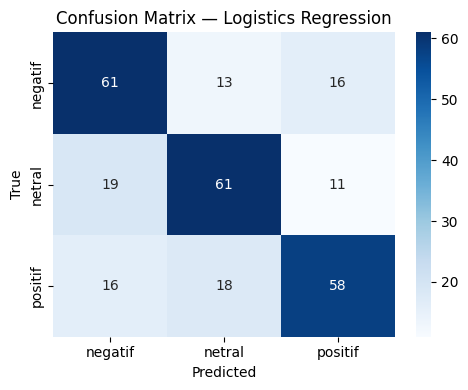

In [25]:
labels = list(le.classes_)
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

print("Train Acc:", model.score(X_train, y_train))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=labels))


print("\nConfusion Matrix (counts):")
print(cm_df)

# heatmap confusion matrix 
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix — Logistics Regression")
plt.tight_layout()
plt.show()

# **2. SVM**

In [12]:
# 1) Train SVM 
svm = LinearSVC(random_state=16)
svm.fit(X_train, y_train)

# 2) Prediksi
y_pred_svm = svm.predict(X_test)

Train Acc: 0.8612191958495461
Accuracy (SVM): 0.63003663003663

Classification Report (SVM):
              precision    recall  f1-score   support

     negatif       0.60      0.61      0.60        90
      netral       0.60      0.69      0.64        91
     positif       0.71      0.59      0.64        92

    accuracy                           0.63       273
   macro avg       0.64      0.63      0.63       273
weighted avg       0.64      0.63      0.63       273



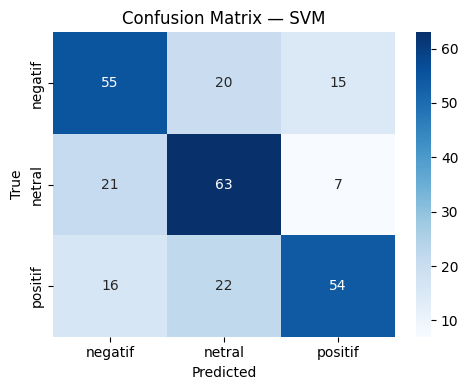

In [26]:
labels = list(le.classes_)
cm = confusion_matrix(y_test, y_pred_svm)

print("Train Acc:", svm.score(X_train, y_train))
print("Accuracy (SVM):", accuracy_score(y_test, y_pred_svm))
print("\nClassification Report (SVM):")
print(classification_report(y_test, y_pred_svm, target_names=labels))

plt.figure(figsize=(5,4))
sns.heatmap(pd.DataFrame(cm, index=labels, columns=labels),
            annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix — SVM")
plt.tight_layout()
plt.show()

# **3. Naive Bayes**

In [16]:
# 1) Train NB 
nb = MultinomialNB()
nb.fit(X_train, y_train)

# 2) Prediksi
y_pred_nb = nb.predict(X_test)

Train Acc: 0.7412451361867705
Accuracy (Naive Bayes): 0.6263736263736264

Classification Report (Naive Bayes):
              precision    recall  f1-score   support

     negatif       0.59      0.70      0.64        90
      netral       0.65      0.56      0.60        91
     positif       0.66      0.62      0.64        92

    accuracy                           0.63       273
   macro avg       0.63      0.63      0.63       273
weighted avg       0.63      0.63      0.63       273



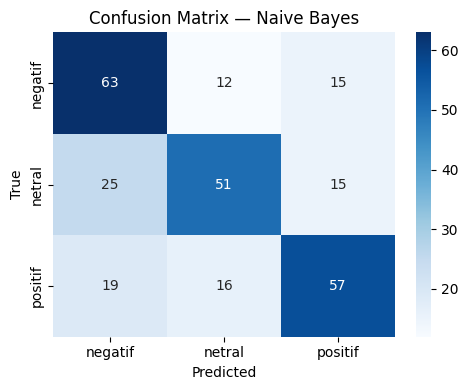

In [27]:
labels = list(le.classes_)
cm = confusion_matrix(y_test, y_pred_nb)

print("Train Acc:", nb.score(X_train, y_train))
print("Accuracy (Naive Bayes):", accuracy_score(y_test, y_pred_nb))
print("\nClassification Report (Naive Bayes):")
print(classification_report(y_test, y_pred_nb, target_names=labels))

plt.figure(figsize=(5,4))
sns.heatmap(pd.DataFrame(cm, index=labels, columns=labels),
            annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix — Naive Bayes")
plt.tight_layout()
plt.show()

# **4. Random Forest**

In [19]:
# 1) Train Random Forest
rf = RandomForestClassifier(n_estimators=300, random_state=16, n_jobs=-1)
rf.fit(X_train.toarray(), y_train)

# 2) Prediksi
y_pred_rf = rf.predict(X_test.toarray())

Train Acc: 0.9922178988326849
Accuracy (RandomForest): 0.5934065934065934

Classification Report (RandomForest):
              precision    recall  f1-score   support

     negatif       0.58      0.50      0.54        90
      netral       0.59      0.73      0.65        91
     positif       0.60      0.55      0.58        92

    accuracy                           0.59       273
   macro avg       0.59      0.59      0.59       273
weighted avg       0.59      0.59      0.59       273



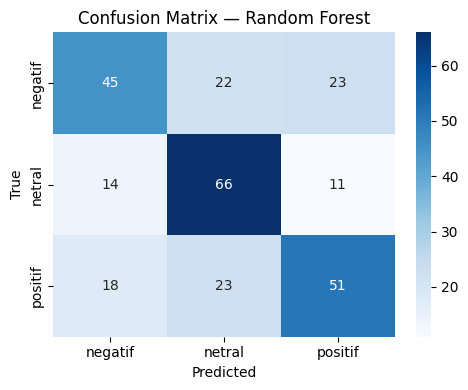

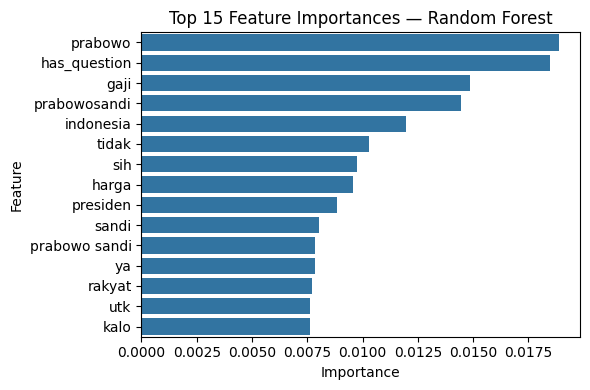

In [28]:
labels = list(le.classes_)
cm = confusion_matrix(y_test, y_pred_rf)

print("Train Acc:", rf.score(X_train, y_train))
print("Accuracy (RandomForest):", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report (RandomForest):")
print(classification_report(y_test, y_pred_rf, target_names=labels))

plt.figure(figsize=(5,4))
sns.heatmap(pd.DataFrame(cm, index=labels, columns=labels),
            annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix — Random Forest")
plt.tight_layout(); plt.show()

feat_names = list(vectorizer.get_feature_names_out()) + ['has_question']
importances = rf.feature_importances_
topk = 15
idx = importances.argsort()[::-1][:topk]

plt.figure(figsize=(6,4))
sns.barplot(x=importances[idx], y=[feat_names[i] for i in idx])
plt.xlabel("Importance"); plt.ylabel("Feature")
plt.title(f"Top {topk} Feature Importances — Random Forest")
plt.tight_layout(); plt.show()